In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import random
from PIL import Image
import matplotlib.pyplot as plt

# Parameters
TRAIN_DIR = "/content/DIV2K/train_HR"
VALID_DIR = "/content/DIV2K/valid_HR"
CROP_SIZE = 128
UPSCALE = 2
N_TRAIN_IMAGES = 500
N_VALID_IMAGES = 50
PATCHES_PER_IMAGE = 10

# Output folders
os.makedirs("prepared_data/train_HR", exist_ok=True)
os.makedirs("prepared_data/train_LR", exist_ok=True)
os.makedirs("prepared_data/val_HR", exist_ok=True)
os.makedirs("prepared_data/val_LR", exist_ok=True)
TEST_DIR = "/content/DIV2K/test_HR"  # Directory with test images
N_TEST_IMAGES = 50

# Output folders for test
os.makedirs("prepared_data/test_HR", exist_ok=True)
os.makedirs("prepared_data/test_LR", exist_ok=True)


In [2]:
def crop_and_downscale(image_path, crop_size, upscale, mode='train'):
    img = Image.open(image_path).convert('RGB')
    w, h = img.size

    patches = []
    for _ in range(PATCHES_PER_IMAGE):
        if w < crop_size or h < crop_size:
            continue
        left = random.randint(0, w - crop_size)
        top = random.randint(0, h - crop_size)
        patch = img.crop((left, top, left + crop_size, top + crop_size))
        hr = patch
        lr = patch.resize((crop_size // upscale, crop_size // upscale), Image.BICUBIC)
        lr = lr.resize((crop_size, crop_size), Image.BICUBIC)
        patches.append((lr, hr))

    # Save patches
    for i, (lr, hr) in enumerate(patches):
        base = os.path.basename(image_path).split('.')[0]
        lr.save(f"prepared_data/{mode}_LR/{base}_{i}.png")
        hr.save(f"prepared_data/{mode}_HR/{base}_{i}.png")

# --- Process training images ---
train_images = sorted(glob(f"{TRAIN_DIR}/*.png"))[:N_TRAIN_IMAGES]

print("Processing training images...")
for path in tqdm(train_images):
    crop_and_downscale(path, CROP_SIZE, UPSCALE, mode='train')

# --- Process validation images ---
val_images = sorted(glob(f"{VALID_DIR}/*.png"))[:N_VALID_IMAGES]

print("Processing validation images...")
for path in tqdm(val_images):
    crop_and_downscale(path, CROP_SIZE, UPSCALE, mode='val')

test_images = sorted(glob(f"{TEST_DIR}/*.png"))[:N_TEST_IMAGES]

print("Processing test images...")
for path in tqdm(test_images):
    crop_and_downscale(path, CROP_SIZE, UPSCALE, mode='test')

print("✅ Data preparation complete.")


Processing training images...


100%|██████████| 500/500 [01:44<00:00,  4.78it/s]


Processing validation images...


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


Processing test images...


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]

✅ Data preparation complete.


In [3]:
!pip install torch torchvision tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch

class SharpnessDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_paths = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])
        self.hr_paths = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)])
        self.transform = T.ToTensor()

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = Image.open(self.lr_paths[idx]).convert('RGB')
        hr = Image.open(self.hr_paths[idx]).convert('RGB')
        return self.transform(lr), self.transform(hr)

# Paths
train_set = SharpnessDataset('prepared_data/train_LR', 'prepared_data/train_HR')
val_set = SharpnessDataset('prepared_data/val_LR', 'prepared_data/val_HR')

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)

test_set = SharpnessDataset('prepared_data/test_LR', 'prepared_data/test_HR')
test_loader = DataLoader(test_set, batch_size=1)



In [12]:
import torchvision.models as models
import torch.nn as nn

class TeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Encoder: ResNet18 backbone
        self.encoder = nn.Sequential(
            resnet.conv1,    # -> 64x64
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,  # -> 32x32
            resnet.layer1,   # -> 32x32
            resnet.layer2,   # -> 16x16
            resnet.layer3,   # -> 8x8
            resnet.layer4    # -> 4x4
        )

        # Decoder: Upsample back to 128x128
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # 4 → 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),  # 8 → 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),   # 16 → 32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),    # 32 → 64
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), nn.ReLU(),    # 64 → 128
            nn.Conv2d(16, 3, kernel_size=3, padding=1), nn.Sigmoid()                      # final RGB output
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [13]:
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding=2), nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1)
        )
    def forward(self, x):
        return self.net(x)


In [14]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher = TeacherModel().to(device)

optimizer = optim.Adam(teacher.parameters(), lr=1e-4)

print(" Training Teacher...")
for epoch in range(10):
    teacher.train()
    loss_total = 0
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        out = teacher(lr)
        loss = F.mse_loss(out, hr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f"[Teacher] Epoch {epoch+1}: Loss = {loss_total / len(train_loader):.4f}")


 Training Teacher...
[Teacher] Epoch 1: Loss = 0.0421
[Teacher] Epoch 2: Loss = 0.0268
[Teacher] Epoch 3: Loss = 0.0239
[Teacher] Epoch 4: Loss = 0.0200
[Teacher] Epoch 5: Loss = 0.0172
[Teacher] Epoch 6: Loss = 0.0153
[Teacher] Epoch 7: Loss = 0.0144
[Teacher] Epoch 8: Loss = 0.0137
[Teacher] Epoch 9: Loss = 0.0132
[Teacher] Epoch 10: Loss = 0.0129


In [15]:
student = StudentModel().to(device)
optimizer_s = optim.Adam(student.parameters(), lr=1e-4)

print("\n🎓Training Student with Teacher knowledge distillation...")
for epoch in range(10):
    student.train()
    loss_total = 0
    for lr, _ in train_loader:
        lr = lr.to(device)
        with torch.no_grad():
            target = teacher(lr)
        out = student(lr)
        loss = F.mse_loss(out, target)
        optimizer_s.zero_grad()
        loss.backward()
        optimizer_s.step()
        loss_total += loss.item()
    print(f"[Student] Epoch {epoch+1}: Loss = {loss_total / len(train_loader):.4f}")


🎓 Training Student with Teacher knowledge distillation...
[Student] Epoch 1: Loss = 0.0430
[Student] Epoch 2: Loss = 0.0080
[Student] Epoch 3: Loss = 0.0072
[Student] Epoch 4: Loss = 0.0066
[Student] Epoch 5: Loss = 0.0062
[Student] Epoch 6: Loss = 0.0059
[Student] Epoch 7: Loss = 0.0058
[Student] Epoch 8: Loss = 0.0056
[Student] Epoch 9: Loss = 0.0055
[Student] Epoch 10: Loss = 0.0053


In [18]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

def evaluate_model(model, loader, label="Set"):
    model.eval()
    scores_ssim, scores_psnr = [], []
    with torch.no_grad():
        for lr, hr in loader:
            lr = lr.to(device)
            output = model(lr).clamp(0, 1)
            pred = output.squeeze().permute(1, 2, 0).cpu().numpy()
            gt = hr.squeeze().permute(1, 2, 0).cpu().numpy()
            scores_ssim.append(ssim(pred, gt, channel_axis=2, data_range=1.0))
            scores_psnr.append(psnr(gt, pred, data_range=1.0))

    print(f"\n {label} - Avg SSIM: {np.mean(scores_ssim):.4f}, Avg PSNR: {np.mean(scores_psnr):.2f} dB")

evaluate_model(student, val_loader, "Validation")
evaluate_model(student, test_loader, "Test")



 Validation - Avg SSIM: 0.9154, Avg PSNR: 22.86 dB

 Test - Avg SSIM: 0.8962, Avg PSNR: 23.14 dB


In [19]:
MODEL_PATH = "student_model.pth"
torch.save(student.state_dict(), MODEL_PATH)
print(f" Student model saved to {MODEL_PATH}")


 Student model saved to student_model.pth


  0%|          | 0/500 [00:00<?, ?it/s]

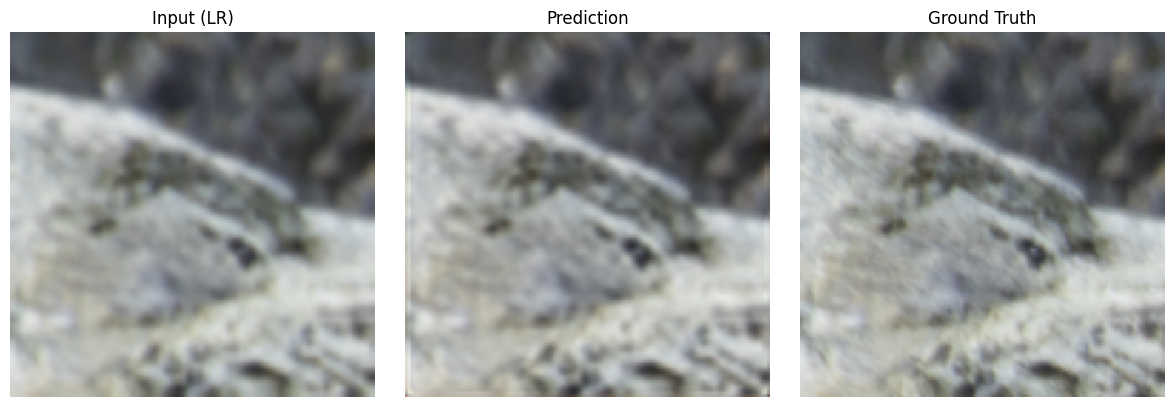

  0%|          | 1/500 [00:01<10:01,  1.20s/it]

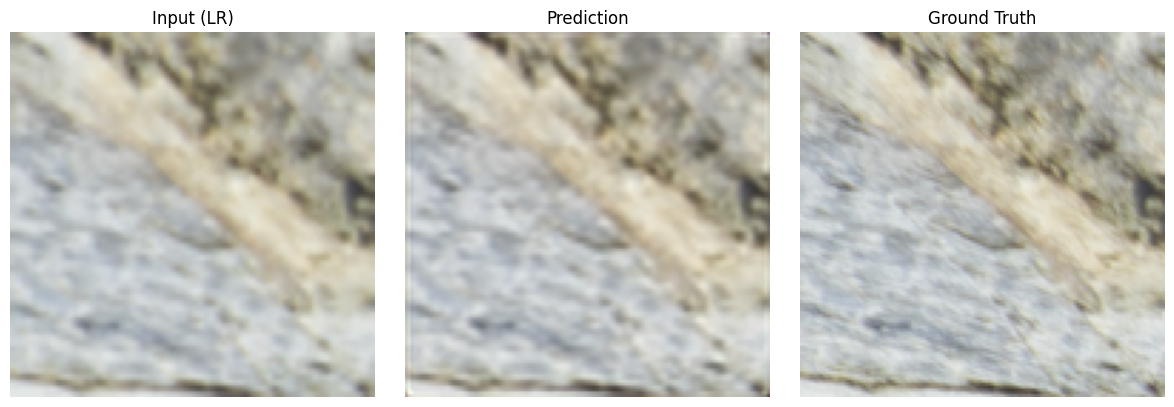

  0%|          | 2/500 [00:01<06:43,  1.23it/s]

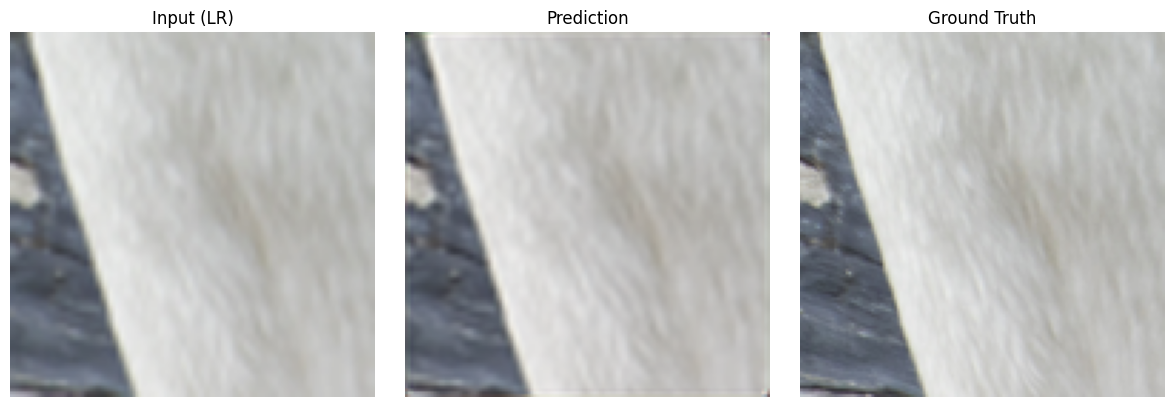

100%|██████████| 500/500 [00:09<00:00, 55.07it/s]


Evaluated 500 images
 Avg SSIM: 0.9005
 Avg PSNR: 32.21 dB


In [ ]:

import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# === Your StudentModel ===
import torch.nn as nn
class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding=2), nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1)
        )
    def forward(self, x):
        return self.net(x)

# --- Paths ---
VAL_LR_DIR = 'prepared_data/val_LR'
VAL_HR_DIR = 'prepared_data/val_HR'
OUTPUT_DIR = 'results'
MODEL_PATH = 'student_model.pth'  # replace if saved under another name

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StudentModel().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# --- Transforms ---
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# --- Evaluation Loop ---
lr_files = sorted(os.listdir(VAL_LR_DIR))
hr_files = sorted(os.listdir(VAL_HR_DIR))

ssim_scores, psnr_scores = [], []

for i, (lr_file, hr_file) in enumerate(tqdm(zip(lr_files, hr_files), total=len(lr_files))):
    lr_img = Image.open(os.path.join(VAL_LR_DIR, lr_file)).convert("RGB")
    hr_img = Image.open(os.path.join(VAL_HR_DIR, hr_file)).convert("RGB")

    input_tensor = to_tensor(lr_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output_tensor = model(input_tensor).clamp(0, 1)

    # Convert output and GT to numpy
    pred_img = to_pil(output_tensor.squeeze().cpu())
    pred_np = np.array(pred_img)
    hr_np = np.array(hr_img)

    # Save predicted image
    pred_img.save(os.path.join(OUTPUT_DIR, f"pred_{i}.png"))

    # Calculate SSIM & PSNR
    ssim = compare_ssim(hr_np, pred_np, channel_axis=2, data_range=255)
    psnr = compare_psnr(hr_np, pred_np, data_range=255)

    ssim_scores.append(ssim)
    psnr_scores.append(psnr)

    # Plot first 3
    if i < 3:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(lr_img)
        axs[0].set_title("Input (LR)")
        axs[1].imshow(pred_img)
        axs[1].set_title("Prediction")
        axs[2].imshow(hr_img)
        axs[2].set_title("Ground Truth")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# --- Final Scores ---
print(f"\nEvaluated {len(lr_files)} images")
print(f" Avg SSIM: {np.mean(ssim_scores):.4f}")
print(f" Avg PSNR: {np.mean(psnr_scores):.2f} dB")
